In [1]:

import numpy as np
import ipykernel
import matplotlib.pyplot as plt
from BCS_casadi import BCS_model, PlotResult
from plot_result import PlotResult
from bcs_envelope import BcsEnvelope

### Nesse codigo, compilei a função fmincon em um executavel MEX, 
## assim o tempo computacional do solver reduz consideravelmente!!
## codegen -lang:c++ solverNMPC -args {uk_1,Hp,Hc,q,r,qu,utg,Ts,nu,ny,ypk,xmk,ymk,pm,DuYsp0,Ain,Bin,Aeq,beq,Dumin,Dumax} -report
# steady-state conditions
xss = np.array([8311024.82175957, 2990109.06207437, 0.00995042241351780, 50, 50])
nx=5
uss = np.vstack([50, 50])
yss = np.vstack([6000142.88550200, 592.126490003812])
## Controller parameters
Hp = 10   ; # prediction horizon
Hc = 2    ; # control horizon
Ts = 2; # sampling time
#--------------------------------------------------------------------------
# constraints on inputs
#--------------------------------------------------------------------------
umin  = np.vstack([35, 0])    # lower bounds of inputs
umax  = np.vstack([65, 100])    # upper bounds of inputs 
dumax = Ts*np.vstack([0.5, 0.5])  # maximum variation of input moves: [0.5 Hz/s; 0.5 #/s]
# ----------------------------------------------
# ------Normalização através dos pesos----------
q = np.hstack([1e6, 1e8]) /(yss.T**2); # weights on controlled variables 
r = np.array([10, 1]) /(uss.T**2); # weights on control actions
qu = 1000 /(uss[1]**2)
ny=2
print("Instancia BCS")
bcs=BCS_model(nx,ny,Hp,Hc,Ts,umin,umax,dumax,q,r,qu)



Dados carregados
Instancia BCS
(4, 4)


In [2]:
#-------------------- Linearizaçao para o EKF -----------------------------
Ak,Bk,Ck,Dk=bcs.matrizes_ekf # Calculo das Jacobianas
# EKF
# Variancia da medição (R)
V = ((0.01/3)*np.diag(yss))**2
# Variancia do modelo (Q)
W = ((0.01/3)*np.diag(xss))**2
# Variancia da estimacao
Mk = W
#
Vruido = ((0.01/3)*np.diag(yss))**2

In [4]:
bcs.envelope.size_env=(3,3)


In [5]:
qk=40
print(bcs.envelope.H_65hz_env([qk]))
bcs.envelope.Hlim(qk)

[1046.96577874]


[array([526.68982195]), array([1046.96577874])]

In [6]:
#--------------------------------------------------------------------------
# Initial condition (preferred steady-state)
#--------------------------------------------------------------------------
uk_1 = np.vstack([50, 50]) # manipulated variable
x0 = np.array([8311024.82175957,2990109.06207437,0.00995042241351780,50,50]); # state variables
ypk = yss
xmk = x0; ymk = yss;  # condição inicial para o EKF
xmk[2] = 0.0106; # inicia a vazao de um x0 diferente para testar converg.
xmk2 = x0; ymk2 = yss; # estados da simulação do modelo nominal
utg = 80;   # target na choke
pm = 2e6;   # pressão da manifold
# Limites de pressao de intake

# ymax[0,0] = yss[0]; # Pressao de intake
# Regiao de operação
hlim = bcs.envelope.Hlim(x0[2]*3600); 
ymin = np.vstack([yss[0],min(hlim)]) # Pressao de intake e  Downtrhust
ymax = np.vstack([yss[0],max(hlim)]) # Pressao de intake e  Uptrhust
# ymin(2,1) = min(hlim); # Downtrhust
# ymax(2,1) = max(hlim); # Uptrhust

hlim

[array([479.34883399]), array([1058.24026003])]

In [7]:
ymax[0,0] = ymin[0,0]; # Pressao de intake

## Limite Up e Downthrust
hlim = bcs.envelope.Hlim(xmk[2]*3600)
ymin[1] = min(hlim)
ymax[1] = max(hlim)

In [8]:
ymin,ymax,hlim

(array([[6.00014289e+06],
        [4.79348834e+02]]),
 array([[6.00014289e+06],
        [1.05824026e+03]]),
 [array([479.34883399]), array([1058.24026003])])

In [9]:
bcs.Dumax(ymax),bcs.Dumin(ymin)

(array([[1.00000000e+00],
        [1.00000000e+00],
        [1.00000000e+00],
        [1.00000000e+00],
        [6.00014289e+06],
        [1.05824026e+03]]),
 array([[-1.00000000e+00],
        [-1.00000000e+00],
        [-1.00000000e+00],
        [-1.00000000e+00],
        [ 6.00014289e+06],
        [ 4.79348834e+02]]))

In [10]:
f_ss,zc_ss,pm_ss,pr_ss= (np.array([50, 50,20e5,1.26e7]))
uss = np.vstack([f_ss,zc_ss]); # Entradas do estacionario
uss

array([[50.],
       [50.]])

In [11]:
# sol=bcs.integrator_ode(xss,uss)
# print(sol)

In [14]:
#--------------------------------------------------------------------------
DuYsp0  = np.vstack([np.zeros((bcs.Hc*bcs.nu,1)), yss]); #
Du=np.zeros((bcs.Hc*bcs.nu,1))
ysp=yss
#--- simulação -------------------------------- ------------------------------
tsim =200;     # seconds 
nsim=int(tsim/Ts);   # number of steps

uk=np.zeros((bcs.nu,int(nsim)))
#print(uk_1,utg,ypk,xmk,ymk,ymk2,pm,DuYsp0,ymin,ymax)
#print(bcs.nmpc_solver(uk_1,utg,ypk,xmk,ymk,ymk2,pm,DuYsp0,ymin,ymax))
Vruido = ((0.01/3)*np.diag(yss[:,0]))**2

Yk=yss
Xk=xss.reshape((xss.shape[0],1))
Ysp=yss
YLim=np.vstack([ymax[1],ymin[1]])
for k in range(nsim):
    #print(k)
    tsim = k*Ts
#     changes on set-points Pintake
    if tsim==Ts:
        ymin[0] = 8.8e6
    elif tsim==50:
        ymin[0] = 6e6
        
    elif tsim==400:
        ymin[0] = 4.2e6
    # else:
    #     bcs.pm = 8e5
    if k==60:
        utg=75
    if k==90:
        utg=50
        
    
    #ymin(1,1) = yss(1);    # Pressao de intake
    ymax[0,0] = ymin[0,0]; # Pressao de intake
    
    ## Limite Up e Downthrust
    hlim = bcs.envelope.Hlim(xmk[2])
    ymin[1] = min(hlim)
    ymax[1] = max(hlim)
    
    #tic
    # print(uk_1,utg,ypk,xmk,ymk,ymk2,pm,DuYsp0,ymin,ymax)
    # print(uk_1)
    Du,ysp=bcs.nmpc_solver(uk_1,utg,ypk,xmk,ymk,ymk2,pm,Du,ysp,ymin,ymax)
    #DuYsp,fval,flag,report = bcs.nmpc_solver(uk_1,utg,ypk,xmk,ymk,ymk2,pm,DuYsp0,ymin,ymax)
    #print(Du,uk_1,ysp.T,ysp[-bcs.ny:,:].T)
    uk[:,k:k+1] = uk_1 + Du[:bcs.Hc,:]
    # J_k[k] = fval  # cost function
    uk_1 = uk_1 + Du[:bcs.Hc,:] # optimal input at time step k
    # iter[0,k] = report.iterations
    # evalObj[1,k] = report.funcCount
    # flags[1,k] = flag
    #DuYsp0 = DuYsp # Estimativa inicial do otmizador
# print(uk)
    ##  Plant
    xpk=bcs.integrator_ode(x0,uk_1) 
    #  Nominal Model
    x0 = xpk
    ypk = bcs.eq_medicao(x0)
    ruido = 5
    ypk = ypk+np.random.multivariate_normal((0,0), Vruido).reshape((bcs.ny,1)) # ruido -> 3x a 5x
    Yk=np.concatenate((Yk,ypk),axis=1)
    Ysp=np.concatenate((Ysp,ysp),axis=1)
    YLim=np.concatenate((YLim,np.vstack([ymax[1],ymin[1]])),axis=1)
    Xk=np.concatenate((Xk,x0.reshape((x0.shape[0],1))),axis=1)





CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.01e+09]] [[0.]]
|> 1 : 1.2237415349262139e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2237415384594478e+08
|> 1 : 1.2237415349262139e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2237415384594478e+08
[[1.40329758e+08]] 0.000176485
|> 1 : 1.2242706658547144e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2242706667389059e+08
|> 1 : 1.2242706658547144e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2242706667389059e+08


CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.3993302e+08]] 4.41654e-05
|> 1 : 1.2241205859919661e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2241205862132350e+08
|> 1 : 1.2241205859919661e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2241205862132350e+08
[[1.39932922e+08]] 1.10524e-05
|> 1 : 1.3988904649051648e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3988904649605373e+08
|> 1 : 1.3988904649051648e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3988904649605373e+08
[[1.39932874e+08]] 2.76586e-06
|> 1 : 1.3991090158956093e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3991090159094661e+08
|> 1 : 1.3991090158956093e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3991090159094661e+08
[[1.39932849e+08]] 6.92156e-07
|> 1 : 1.3992185190927446e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3992185190962124e+08
|> 1 : 1.3992185190927446e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3992185190962124e+08
[[1.39932837e+08]] 1.73212e-07
|> 1 : 1.3992733416578156e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3992733416586834e+08
|> 1 : 1.3992733416578156e+08
|> 2 :

CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932826e+08]] 2.71456e-09
|> 1 : 1.3993213729858500e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993213729858637e+08
|> 1 : 1.3993213729858500e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993213729858637e+08
[[1.39932826e+08]] 6.79319e-10
|> 1 : 1.3993248088156968e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993248088157001e+08
|> 1 : 1.3993248088156968e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993248088157001e+08
[[1.39932825e+08]] 1.7e-10
|> 1 : 1.3993265276320130e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993265276320139e+08
|> 1 : 1.3993265276320130e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993265276320139e+08
[[1.39932825e+08]] 4.25424e-11
|> 1 : 1.3993273874803874e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993273874803877e+08
|> 1 : 1.3993273874803874e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993273874803877e+08


CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 1.06462e-11
|> 1 : 1.3993278176221144e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993278176221144e+08
|> 1 : 1.3993278176221144e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993278176221144e+08
[[1.39932825e+08]] 2.66422e-12
|> 1 : 1.3993280328011328e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993280328011328e+08
|> 1 : 1.3993280328011328e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993280328011328e+08
[[1.39932825e+08]] 6.66721e-13
|> 1 : 1.3993281404445747e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993281404445747e+08
|> 1 : 1.3993281404445747e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993281404445747e+08


CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 1.66847e-13
|> 1 : 1.3993281942932373e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993281942932373e+08
|> 1 : 1.3993281942932373e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993281942932373e+08
[[1.39932825e+08]] 4.17534e-14
|> 1 : 1.3993282212310317e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282212310317e+08
|> 1 : 1.3993282212310317e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282212310317e+08
[[1.39932825e+08]] 1.04488e-14
|> 1 : 1.3993282347066659e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282347066659e+08
|> 1 : 1.3993282347066659e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282347066659e+08


CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 2.61481e-15
|> 1 : 1.3993282414478493e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282414478493e+08
|> 1 : 1.3993282414478493e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282414478493e+08
[[1.39932825e+08]] 6.54356e-16
|> 1 : 1.3993282448201275e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282448201275e+08
|> 1 : 1.3993282448201275e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282448201275e+08
[[1.39932825e+08]] 1.63752e-16
|> 1 : 1.3993282465071073e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282465071073e+08
|> 1 : 1.3993282465071073e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282465071073e+08
[[1.39932825e+08]] 4.0979e-17
|> 1 : 1.3993282473510179e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282473510179e+08
|> 1 : 1.3993282473510179e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282473510179e+08


CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 1.0255e-17
|> 1 : 1.3993282477731872e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282477731872e+08
|> 1 : 1.3993282477731872e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282477731872e+08
[[1.39932825e+08]] 2.56631e-18
|> 1 : 1.3993282479843748e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282479843748e+08
|> 1 : 1.3993282479843748e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282479843748e+08
[[1.39932825e+08]] 6.4222e-19
|> 1 : 1.3993282480900225e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282480900225e+08
|> 1 : 1.3993282480900225e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282480900225e+08


CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 1.60715e-19
|> 1 : 1.3993282481428725e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481428725e+08
|> 1 : 1.3993282481428725e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481428725e+08
[[1.39932825e+08]] 4.0219e-20
|> 1 : 1.3993282481693107e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481693107e+08
|> 1 : 1.3993282481693107e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481693107e+08
[[1.39932825e+08]] 1.00648e-20
|> 1 : 1.3993282481825352e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481825352e+08
|> 1 : 1.3993282481825352e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481825352e+08


CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 2.51871e-21
|> 1 : 1.3993282481891507e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481891507e+08
|> 1 : 1.3993282481891507e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481891507e+08
[[1.39932825e+08]] 6.30307e-22
|> 1 : 1.3993282481924611e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481924611e+08
|> 1 : 1.3993282481924611e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481924611e+08
[[1.39932825e+08]] 1.57736e-22
|> 1 : 1.3993282481941178e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481941178e+08
|> 1 : 1.3993282481941178e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481941178e+08
[[1.39932825e+08]] 3.94743e-23
|> 1 : 1.3993282481949469e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481949469e+08
|> 1 : 1.3993282481949469e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481949469e+08


CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 9.87867e-24
|> 1 : 1.3993282481953600e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481953600e+08
|> 1 : 1.3993282481953600e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481953600e+08
[[1.39932825e+08]] 2.47188e-24
|> 1 : 1.3993282481955683e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481955683e+08
|> 1 : 1.3993282481955683e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481955683e+08
[[1.39932825e+08]] 6.18443e-25
|> 1 : 1.3993282481956714e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481956714e+08
|> 1 : 1.3993282481956714e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481956714e+08
[[1.39932825e+08]] 1.5469e-25
|> 1 : 1.3993282481957230e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957230e+08
|> 1 : 1.3993282481957230e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957230e+08


CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 3.86724e-26
|> 1 : 1.3993282481957477e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957477e+08
|> 1 : 1.3993282481957477e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957477e+08
[[1.39932825e+08]] 9.68787e-27
|> 1 : 1.3993282481957614e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957614e+08
|> 1 : 1.3993282481957614e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957614e+08
[[1.39932825e+08]] 2.42197e-27
|> 1 : 1.3993282481957677e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957677e+08
|> 1 : 1.3993282481957677e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957677e+08
[[1.39932825e+08]] 6.10445e-28
|> 1 : 1.3993282481957737e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957737e+08
|> 1 : 1.3993282481957737e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957737e+08


CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 1.55103e-28
|> 1 : 1.3993282481957740e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957740e+08
|> 1 : 1.3993282481957740e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957740e+08
[[1.39932825e+08]] 3.87757e-29
|> 1 : 1.3993282481957746e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957746e+08
|> 1 : 1.3993282481957746e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957746e+08
[[1.39932825e+08]] 1.03294e-29
|> 1 : 1.3993282481957763e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957763e+08
|> 1 : 1.3993282481957763e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957763e+08
[[1.39932825e+08]] 2.58236e-30
|> 1 : 1.3993282481957763e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957763e+08
|> 1 : 1.3993282481957763e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957763e+08


CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 6.45589e-31
|> 1 : 1.3993282481957763e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957763e+08
|> 1 : 1.3993282481957763e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957763e+08
[[1.39932825e+08]] 1.61397e-31
|> 1 : 1.3993282481957763e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957763e+08
|> 1 : 1.3993282481957763e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957763e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08


CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08


CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08


CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08


CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08


CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993282481957766e+08
[[1.39932825e+08]] 4.03493e-32
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993283481957766e+08
|> 1 : 1.3993282481957766e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.3993283481957766e+08
[[1.39932825e+08]] 0.004995
|> 1 : 1.0523767255051941e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0523767505301878e+08
|> 1 : 1.0523767255051941e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0523767505301878e+08


CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02306446e+08]] 0.00125
|> 1 : 1.0578056308650051e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0578056371275082e+08
|> 1 : 1.0578056308650051e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0578056371275082e+08
[[1.0230574e+08]] 0.000312812
|> 1 : 1.0198333663965312e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0198333679637222e+08
|> 1 : 1.0198333663965312e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0198333679637222e+08
[[1.02305387e+08]] 7.82812e-05
|> 1 : 1.0214515361586812e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0214515365508707e+08
|> 1 : 1.0214515361586812e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0214515365508707e+08


CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305211e+08]] 1.95899e-05
|> 1 : 1.0222531406381439e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0222531407362893e+08
|> 1 : 1.0222531406381439e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0222531407362893e+08
[[1.02305123e+08]] 4.90237e-06
|> 1 : 1.0226521902748446e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0226521902994055e+08
|> 1 : 1.0226521902748446e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0226521902994055e+08
[[1.02305078e+08]] 1.22682e-06
|> 1 : 1.0228513284834236e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0228513284895700e+08
|> 1 : 1.0228513284834236e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0228513284895700e+08


CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305056e+08]] 3.07011e-07
|> 1 : 1.0229508259668228e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0229508259683609e+08
|> 1 : 1.0229508259668228e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0229508259683609e+08
[[1.02305045e+08]] 7.68294e-08
|> 1 : 1.0230005683414409e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0230005683418258e+08
|> 1 : 1.0230005683414409e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.0230005683418258e+08
[[1.0230504e+08]] 1.92266e-08
|> 1 : 1.2225884279871608e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225884279872571e+08
|> 1 : 1.2225884279871608e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225884279872571e+08


CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305037e+08]] 4.81145e-09
|> 1 : 1.2225878386737630e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225878386737871e+08
|> 1 : 1.2225878386737630e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225878386737871e+08
[[1.02305036e+08]] 1.20406e-09
|> 1 : 1.2225875425397184e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225875425397244e+08
|> 1 : 1.2225875425397184e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225875425397244e+08


CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305035e+08]] 3.01317e-10
|> 1 : 1.2225873943984735e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225873943984750e+08
|> 1 : 1.2225873943984735e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225873943984750e+08
[[1.02305035e+08]] 7.54045e-11
|> 1 : 1.2225873202910915e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225873202910919e+08
|> 1 : 1.2225873202910915e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225873202910919e+08


CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305034e+08]] 1.887e-11
|> 1 : 1.2225872832189545e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872832189547e+08
|> 1 : 1.2225872832189545e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872832189547e+08
[[1.02305034e+08]] 4.72221e-12
|> 1 : 1.2225872646736395e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872646736395e+08
|> 1 : 1.2225872646736395e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872646736395e+08


CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305034e+08]] 1.18173e-12
|> 1 : 1.2225872553963535e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872553963535e+08
|> 1 : 1.2225872553963535e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872553963535e+08
[[1.02305034e+08]] 2.95729e-13
|> 1 : 1.2225872507553925e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872507553925e+08
|> 1 : 1.2225872507553925e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872507553925e+08


CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305034e+08]] 7.40061e-14
|> 1 : 1.2225872484337530e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872484337530e+08
|> 1 : 1.2225872484337530e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872484337530e+08
[[1.02305034e+08]] 1.852e-14
|> 1 : 1.2225872472723523e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872472723523e+08
|> 1 : 1.2225872472723523e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872472723523e+08


CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305034e+08]] 4.63463e-15
|> 1 : 1.2225872466913623e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872466913623e+08
|> 1 : 1.2225872466913623e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872466913623e+08
[[1.02305034e+08]] 1.15982e-15
|> 1 : 1.2225872464007224e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872464007224e+08
|> 1 : 1.2225872464007224e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872464007224e+08


CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305034e+08]] 2.90244e-16
|> 1 : 1.2225872462553297e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872462553297e+08
|> 1 : 1.2225872462553297e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872462553297e+08
[[1.02305034e+08]] 7.26336e-17
|> 1 : 1.2225872461825974e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461825974e+08
|> 1 : 1.2225872461825974e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461825974e+08
[[1.02305034e+08]] 1.81765e-17
|> 1 : 1.2225872461462131e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461462131e+08
|> 1 : 1.2225872461462131e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461462131e+08


CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305034e+08]] 4.54868e-18
|> 1 : 1.2225872461280116e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461280116e+08
|> 1 : 1.2225872461280116e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461280116e+08
[[1.02305034e+08]] 1.13831e-18
|> 1 : 1.2225872461189051e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461189051e+08
|> 1 : 1.2225872461189051e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461189051e+08
[[1.02305034e+08]] 2.84861e-19
|> 1 : 1.2225872461143509e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461143509e+08
|> 1 : 1.2225872461143509e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461143509e+08


CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[1.02305034e+08]] 7.12865e-20
|> 1 : 1.2225872461120711e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461120711e+08
|> 1 : 1.2225872461120711e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225872461120711e+08
[[1.02305034e+08]] 1.78395e-20
|> 1 : 1.2225872461109316e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225897461109325e+08
|> 1 : 1.2225872461109316e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.2225897461109325e+08
[[1.02305034e+08]] 0.124875
|> 1 : 1.8174641053623578e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.8174647309872019e+08
|> 1 : 1.8174641053623578e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.8174647309872019e+08


CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

[[74923341.57435806]] 0.03125
|> 1 : 6.0702807006989405e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 6.0702822663247213e+07
|> 1 : 6.0702807006989405e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 6.0702822663247213e+07
[[74910636.12373304]] 0.00782031
|> 1 : 6.8548707745995700e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 6.8548711663973242e+07
|> 1 : 6.8548707745995700e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 6.8548711663973242e+07
[[74904278.31887823]] 0.00195703
|> 1 : 7.1885285899151638e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 7.1885286879625276e+07
|> 1 : 7.1885285899151638e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 7.1885286879625276e+07
[[74901097.35098064]] 0.000489747
|> 1 : 7.3429088798237726e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 7.3429089043601185e+07
|> 1 : 7.3429088798237726e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 7.3429089043601185e+07


CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


[[74899505.95284528]] 0.000122559
|> 1 : 7.4172389507517785e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 7.4172389568919972e+07
|> 1 : 7.4172389507517785e+07
|> 2 : 0.0000000000000000e+00
|> 0 : 7.4172389568919972e+07
[[74898709.82626049]] 3.06704e-05
|> 1 : 1.1983370257474777e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.1983370259011367e+08
|> 1 : 1.1983370257474777e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.1983370259011367e+08
[[74898311.55656123]] 7.67527e-06
|> 1 : 1.1983698133273873e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.1983698133658405e+08
|> 1 : 1.1983698133273873e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.1983698133658405e+08
[[74898112.32032338]] 1.92074e-06
|> 1 : 1.1983858703180131e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.1983858703276360e+08
|> 1 : 1.1983858703180131e+08
|> 2 : 0.0000000000000000e+00
|> 0 : 1.1983858703276360e+08


CasADi - 2022-09-05 20:54:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2022-09-05 20:54:56 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

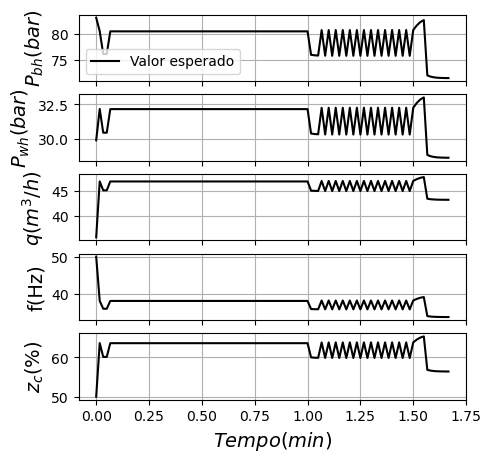

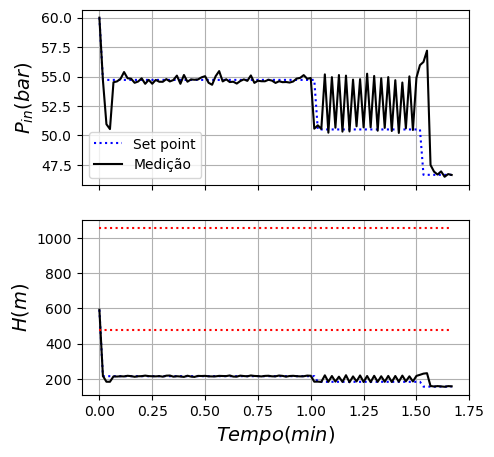

In [15]:
grafico=PlotResult()
grafico.plot_resultado(Xk,uk)
grafico.plot_y(Ysp,Yk,YLim)
plt.show()

Text(39.81410928661445, 224.9965170589292, 't=5')

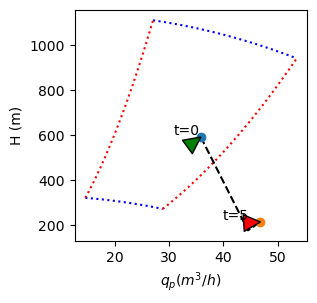

In [ ]:

bcs.envelope.grafico_envelope(Xk,Yk)

